In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from fbprophet import Prophet
from pylab import rcParams
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = (22,5)

In [2]:
FILE_PATH = "../dataset/excel_fpt.csv"
TEST_SIZE = 30
TEST_HORIZON = 7
SEASONALITY = False

In [3]:
def MAPE_point(true_value, predict_value):
    return "MAPE for one day: " + str(100 * np.abs((true_value - predict_value)/true_value))

def MAPE_range(true_values, predict_value):
    percen_errors = []
    for i in range(len(true_values)):
        percen_errors.append(100 * np.abs((true_values[i] - predict_values[i])/true_values[i]))
    return "MAPE for range {} days: ".format(TEST_SIZE) + str(sum(percen_errors)/len(percen_errors))

In [4]:
df = pd.read_csv(FILE_PATH)
df.head()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
0,FPT,20201216,57.2,57.5,57.0,57.1,1995530
1,FPT,20201215,57.5,57.6,56.6,56.7,2666900
2,FPT,20201214,57.0,58.0,56.9,57.2,1443760
3,FPT,20201211,56.6,57.0,56.3,57.0,1750270
4,FPT,20201210,57.0,57.7,56.5,56.5,2112490


In [5]:
df.tail()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
3485,FPT,20061219,27.4356,27.4356,27.4356,27.4356,137520
3486,FPT,20061218,26.1371,26.1371,26.1371,26.1372,215790
3487,FPT,20061215,24.8952,24.8952,24.8952,24.8952,265300
3488,FPT,20061214,23.7097,23.7097,23.7097,23.7097,280710
3489,FPT,20061213,22.5807,22.5807,22.5807,22.5807,83530


In [6]:
columns = df.columns
columns_remove_bracket = [label.replace("<","").replace(">","") for label in columns]
columns_to_replace = {columns[i]: columns_remove_bracket[i] for i in range(len(df.columns))}
df.rename(columns=columns_to_replace, inplace=True)
df.drop(["Ticker","Open","High","Low","Volume"], axis=1, inplace=True)
df["DTYYYYMMDD"] = pd.to_datetime(df["DTYYYYMMDD"], format="%Y%m%d", errors="coerce")
df.rename(columns={"DTYYYYMMDD": "ds", "Close": "y"}, inplace=True)
df.sort_values(by="ds", inplace=True, ascending=True)
df.reset_index(inplace=True, drop=True)
df.head()

,ds,y
0,2006-12-13,22.5807
1,2006-12-14,23.7097
2,2006-12-15,24.8952
3,2006-12-18,26.1372
4,2006-12-19,27.4356


In [7]:
df = df[df["ds"].dt.year >= 2010].reset_index()
df.drop("index", axis=1,inplace=True)
df.head()

,ds,y
0,2010-01-04,11.4774
1,2010-01-05,11.4774
2,2010-01-06,11.2687
3,2010-01-07,11.1991
4,2010-01-08,10.8513


In [8]:
total = len(df)
x_train, x_test = df[:total-TEST_SIZE].copy(), df[total-TEST_SIZE:].copy()
x_test.reset_index(inplace=True)
x_test.drop("index", axis=1, inplace=True)
total, x_train.shape, x_test.shape

(2733, (2703, 2), (30, 2))

In [9]:
model = Prophet(daily_seasonality=False, n_changepoints=100, changepoint_prior_scale=0.5, changepoint_range=0.99)
model.fit(x_train)

In [10]:
# df_future = model.make_future_dataframe(periods=len(x_test), include_history=False)
df_future = x_test.drop(columns=["y"])
df_future.reset_index(inplace=True, drop=True)
df_future.head()

,ds
0,2020-11-05
1,2020-11-06
2,2020-11-09
3,2020-11-10
4,2020-11-11


In [11]:
forecast = model.predict(df_future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-11-05,53.139541,52.165070,54.244406
1,2020-11-06,53.238216,52.260045,54.296674
2,2020-11-09,53.445187,52.454376,54.498646
3,2020-11-10,53.560470,52.559657,54.551762
4,2020-11-11,53.671890,52.706204,54.678571


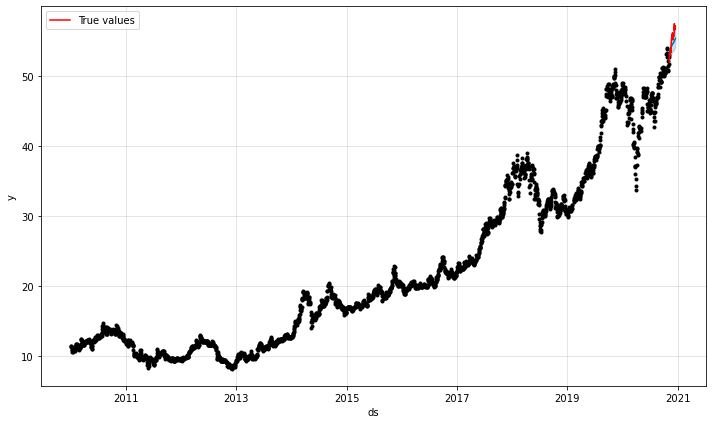

In [12]:
figure_1 = model.plot(forecast)
x_test_clone = x_test.copy()
x_test_clone.set_index("ds", inplace=True)
plt.plot(x_test_clone, color="red", label="True values")
plt.legend()

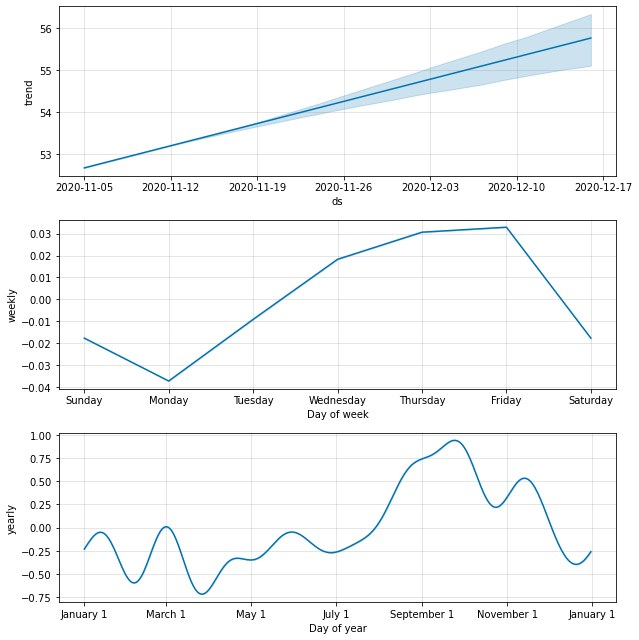

In [13]:
figure_2 = model.plot_components(forecast)

In [14]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-11-05,52.678192,52.165070,54.244406,52.678192,52.678192,0.461349,0.461349,0.461349,0.030668,0.030668,0.030668,0.430681,0.430681,0.430681,0.0,0.0,0.0,53.139541
1,2020-11-06,52.753259,52.260045,54.296674,52.753259,52.753259,0.484958,0.484958,0.484958,0.032940,0.032940,0.032940,0.452018,0.452018,0.452018,0.0,0.0,0.0,53.238216
2,2020-11-09,52.978459,52.454376,54.498646,52.978459,52.978459,0.466728,0.466728,0.466728,-0.037303,-0.037303,-0.037303,0.504031,0.504031,0.504031,0.0,0.0,0.0,53.445187
3,2020-11-10,53.053525,52.559657,54.551762,53.053525,53.053525,0.506945,0.506945,0.506945,-0.009154,-0.009154,-0.009154,0.516099,0.516099,0.516099,0.0,0.0,0.0,53.560470
4,2020-11-11,53.128592,52.706204,54.678571,53.128592,53.128592,0.543298,0.543298,0.543298,0.018280,0.018280,0.018280,0.525018,0.525018,0.525018,0.0,0.0,0.0,53.671890


$\overline y$ = trend + weekly + yearly (không cộng cho additive terms)

In [15]:
x_test.head()

,ds,y
0,2020-11-05,52.0
1,2020-11-06,52.4
2,2020-11-09,53.4
3,2020-11-10,53.0
4,2020-11-11,53.0


In [16]:
forecast[["ds", "yhat"]].head()

,ds,yhat
0,2020-11-05,53.139541
1,2020-11-06,53.238216
2,2020-11-09,53.445187
3,2020-11-10,53.560470
4,2020-11-11,53.671890


## Validation

In [17]:
true_values = x_test["y"].values
true_values.shape

(30,)

In [18]:
predict_values = forecast["yhat"].values
predict_values.shape

(30,)

In [19]:
MAPE_point(true_values[0], predict_values[0])

'MAPE for one day: 2.1914252134680288'

In [20]:
MAPE_range(true_values, predict_values)

'MAPE for range 30 days: 1.7474454330532638'

## Rolling leanring

In [21]:
def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

In [ ]:
true_values, predict_values = [], []
model_rolling = None

for i in tqdm(range(TEST_HORIZON)):
#     print(x_train)
    if (i == 0):
        model_rolling = Prophet(n_changepoints=100,changepoint_range=0.99, changepoint_prior_scale=0.5).fit(x_train)
    else:
        model_rolling = Prophet(n_changepoints=100, changepoint_range=0.99, changepoint_prior_scale=0.5).fit(x_train, init=stan_init(model_rolling))
        
    true_values.append(x_test.iloc[i,1])
    sample = x_test.iloc[i,:].copy()
    future_need_predict = pd.DataFrame({"ds": [sample[0]]})
    predict_df = model_rolling.predict(future_need_predict)
    predict_values.append(predict_df['yhat'][0])
    x_train = x_train.append(x_test.iloc[i,:])
    

 71%|████████████████████████████████████████████████████████████                        | 5/7 [04:09<01:35, 47.71s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
MAPE_range(true_values, predict_values)

In [ ]:
plt.plot(np.arange(len(true_values)), true_values, color="blue", label="True values")
plt.plot(np.arange(len(predict_values)), predict_values, color="red", label="Predict values")
plt.legend()
plt.show()